### Importing libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('kc_house_data_train.csv')

In [3]:
data.head()

Unnamed: 0          id             date      price  bedrooms  bathrooms  \
0           0  2591820310  20141006T000000   365000.0         4       2.25   
1           1  7974200820  20140821T000000   865000.0         5       3.00   
2           2  7701450110  20140815T000000  1038000.0         4       2.50   
3           3  9522300010  20150331T000000  1490000.0         3       3.50   
4           4  9510861140  20140714T000000   711000.0         3       2.50   

   sqft_living  sqft_lot  floors  waterfront  ...  grade  sqft_above  \
0         2070      8893     2.0           0  ...      8        2070   
1         2900      6730     1.0           0  ...      8        1830   
2         3770     10893     2.0           0  ...     11        3770   
3         4560     14608     2.0           0  ...     12        4560   
4         2550      5376     2.0           0  ...      9        2550   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1986             0    98058  47.4388 -122.162   
1           1070      1977             0    98115  47.6784 -122.285   
2              0      1997             0    98006  47.5646 -122.129   
3              0      1990             0    98034  47.6995 -122.228   
4              0      2004             0    98052  47.6647 -122.083   

   sqft_living15  sqft_lot15  
0           2390        7700  
1           2370        6283  
2           3710        9685  
3           4050       14226  
4           2250        4050  

[5 rows x 22 columns]

### Dropping the extra index column

In [4]:
data = data.drop(columns = 'Unnamed: 0')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 21 columns):
id               17290 non-null int64
date             17290 non-null object
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.8+ MB


### Checking the data and fixing outliers

Bathrooms and bedrooms both have some anamolous stuff- I converted all the zeros to ones and changed the bedroom counts above 10 to 10

In [41]:
np.where(data.bathrooms < 1)

(array([  350,   483,   543,  1120,  1122,  1310,  1379,  1381,  1438,
         1487,  1540,  1622,  1696,  2329,  2430,  2692,  3032,  3123,
         3748,  3851,  4201,  4622,  4921,  5072,  5301,  5424,  5489,
         5612,  6966,  7093,  7161,  7263,  7309,  8000,  8224,  8710,
         9060,  9193,  9286,  9469,  9516,  9796, 10067, 10086, 10559,
        11214, 11560, 11716, 11753, 12578, 12662, 12674, 12982, 13508,
        14509, 14987, 15465, 15703, 16126, 16260, 16398, 16779, 17163]),)

In [43]:
data['bathrooms'] = data.bathrooms.apply(lambda x: 1 if x < 1 else x)

In [62]:
data['bedrooms'].sort_values()

11155     1
2299      1
6261      1
16465     1
1588      1
         ..
8597     10
17114    10
3680     10
2356     10
11181    10
Name: bedrooms, Length: 17290, dtype: int64

In [61]:
data['bedrooms'] = data.bedrooms.apply(lambda x: 10 if x > 10 else x)
data['bedrooms'] = data.bedrooms.apply(lambda x: 1 if x < 1 else x)

### Creating histograms of all variables 
Examining which are continuous and categorical

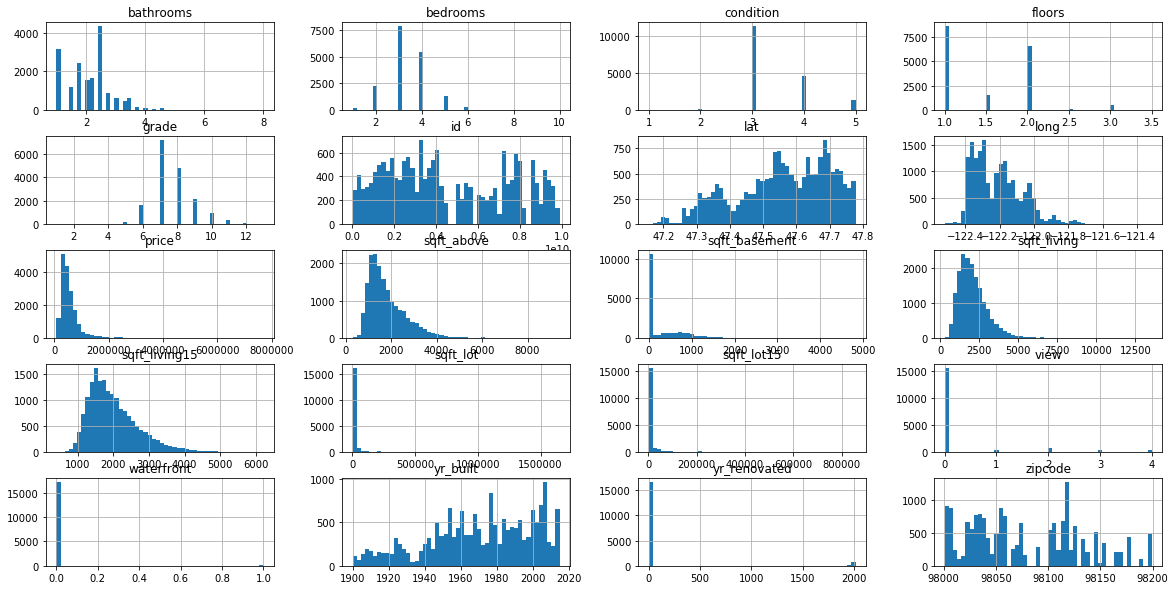

In [63]:
data.hist(bins = 50, figsize = (20,10))
plt.show()

In [ ]:
continuous variables - price, sqft_above, sqft_basement, sqft_living, sqft_living15, sqft_lot, yr_built

categoricals - bathrooms, bedrooms, condition, floors, grade, view, waterfront

### Reformatting the date column
* Dropped the hours and minutes and converted to Datetime
* Broke the category down into seasons and explored the differences

In [74]:
data.date = data.date.apply(lambda x: x[0:8])
data.date = pd.to_datetime(data.date)

In [ ]:
def season(column):
    '''takes in a column of datetime objects and converts them into numerical identifiers in 3 month blocks'''
    new_column = []
    for x in column:
        if x in pd.date_range(start = '2014-05-02', end= '2014-08-24'):
            new_column.append(1)
        elif x in pd.date_range(start = '2014-08-25', end= '2014-11-24'):
            new_column.append(2)
        elif x in pd.date_range(start = '2014-11-25', end= '2015-02-24'):
            new_column.append(3)
        elif x in pd.date_range(start = '2015-02-25', end= '2015-05-27'):
            new_column.append(4)
        else:
            new_column.append('out of range') 
    return new_column

In [75]:
data['season'] = season(data.date)

### Combining yr_built and yr_renovated into a new variable

In [67]:
def new_construction(renovated, built):
    '''takes in a column of renovation years and initial construction and returns a new column which includes the date of the renovation if any, else the construction date'''
    new_const = []
    for i in list(range(len(renovated))):
        if renovated[i] != 0:
            new_const.append(renovated[i])
        else:
            new_const.append(built[i]) 
    return new_const

In [69]:
data['new_const'] = new_construction(data.yr_renovated, data.yr_built)

### Performing a train/test split stratified by zipcodes

In [70]:
train_set, test_set = train_test_split(data, test_size=0.25, random_state=99, stratify=data.zipcode)

In [71]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 7018 to 3888
Data columns (total 22 columns):
id               12967 non-null int64
date             12967 non-null object
price            12967 non-null float64
bedrooms         12967 non-null int64
bathrooms        12967 non-null float64
sqft_living      12967 non-null int64
sqft_lot         12967 non-null int64
floors           12967 non-null float64
waterfront       12967 non-null int64
view             12967 non-null int64
condition        12967 non-null int64
grade            12967 non-null int64
sqft_above       12967 non-null int64
sqft_basement    12967 non-null int64
yr_built         12967 non-null int64
yr_renovated     12967 non-null int64
zipcode          12967 non-null int64
lat              12967 non-null float64
long             12967 non-null float64
sqft_living15    12967 non-null int64
sqft_lot15       12967 non-null int64
new_const        12967 non-null int64
dtypes: float64(5), int64(16), object(1)
m

In [72]:
data.zipcode.value_counts()/len(data)

98052    0.027415
98115    0.026894
98103    0.026663
98038    0.026316
98117    0.025275
           ...   
98102    0.004627
98010    0.004280
98024    0.003759
98148    0.002487
98039    0.002429
Name: zipcode, Length: 70, dtype: float64

In [73]:
train_set.zipcode.value_counts()/len(train_set)

98052    0.027377
98115    0.026914
98103    0.026683
98038    0.026298
98117    0.025295
           ...   
98102    0.004627
98010    0.004319
98024    0.003779
98039    0.002468
98148    0.002468
Name: zipcode, Length: 70, dtype: float64

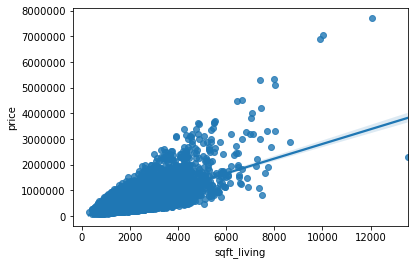

In [19]:
sns.regplot(train_set.sqft_living, train_set.price)

In [20]:
train_set.sqft_living.corr(train_set.price)

0.7027785354390488

In [77]:
y_train = train_set.price
TestVar1 = pd.DataFrame(train_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view']])

dummy = DummyRegressor()

dummy.fit(TestVar1, y_train)

dummy.score(TestVar1, y_train)

0.0

In [12]:
y_pred = dummy.predict(X_train)
dummy_rmse = mean_squared_error(y_train, y_pred)
dummy_rmse**.5

376408.8360546109

In [78]:
lr = LinearRegression()
lr.fit(TestVar1, y_train)
y_pred = lr.predict(TestVar1)
lr.score(TestVar1, y_train)

0.6338966175462856

In [79]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

227751.7278533808

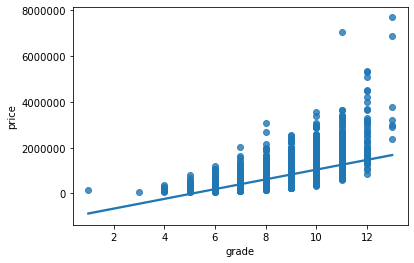

In [26]:
sns.regplot(train_set.grade, train_set.price)

In [83]:
train_set.corr()

id     price  bedrooms  bathrooms  sqft_living  \
id              1.000000 -0.016591 -0.010404  -0.000730    -0.016381   
price          -0.016591  1.000000  0.304535   0.526209     0.702779   
bedrooms       -0.010404  0.304535  1.000000   0.501970     0.566553   
bathrooms      -0.000730  0.526209  0.501970   1.000000     0.756720   
sqft_living    -0.016381  0.702779  0.566553   0.756720     1.000000   
sqft_lot       -0.128666  0.094655  0.027535   0.089312     0.171821   
floors          0.020817  0.253638  0.169460   0.497167     0.353441   
waterfront      0.001906  0.289324 -0.005215   0.067710     0.114909   
view            0.006129  0.404177  0.081960   0.193810     0.291671   
condition      -0.013081  0.040932  0.023408  -0.124633    -0.060336   
grade           0.000707  0.662303  0.355518   0.669387     0.762612   
sqft_above     -0.013205  0.607164  0.473200   0.692612     0.876228   
sqft_basement  -0.009378  0.326683  0.293649   0.279450     0.441987   
yr_built        0.012937  0.048414  0.153341   0.504886     0.315209   
yr_renovated   -0.021312  0.124758  0.015874   0.054357     0.055495   
zipcode        -0.001638 -0.049243 -0.146018  -0.203427    -0.193808   
lat            -0.002615  0.301947 -0.003592   0.024880     0.051413   
long            0.020486  0.019090  0.124712   0.224344     0.235962   
sqft_living15  -0.006179  0.584066  0.389238   0.572355     0.755866   
sqft_lot15     -0.134888  0.085790  0.025852   0.088774     0.182109   
renovated2000s -0.020622  0.100522  0.034375   0.068773     0.052087   
season          0.008792 -0.005159 -0.015202  -0.031684    -0.034994   

                sqft_lot    floors  waterfront      view  condition  ...  \
id             -0.128666  0.020817    0.001906  0.006129  -0.013081  ...   
price           0.094655  0.253638    0.289324  0.404177   0.040932  ...   
bedrooms        0.027535  0.169460   -0.005215  0.081960   0.023408  ...   
bathrooms       0.089312  0.497167    0.067710  0.193810  -0.124633  ...   
sqft_living     0.171821  0.353441    0.114909  0.291671  -0.060336  ...   
sqft_lot        1.000000 -0.004234    0.017165  0.085187  -0.011616  ...   
floors         -0.004234  1.000000    0.026593  0.022483  -0.265105  ...   
waterfront      0.017165  0.026593    1.000000  0.422921   0.014966  ...   
view            0.085187  0.022483    0.422921  1.000000   0.045556  ...   
condition      -0.011616 -0.265105    0.014966  0.045556   1.000000  ...   
grade           0.112873  0.459686    0.096653  0.254022  -0.139043  ...   
sqft_above      0.185592  0.526995    0.081033  0.170841  -0.155406  ...   
sqft_basement   0.010722 -0.248273    0.087372  0.286633   0.164199  ...   
yr_built        0.057854  0.478955   -0.022264 -0.048488  -0.359997  ...   
yr_renovated    0.004159  0.012277    0.088749  0.095231  -0.062676  ...   
zipcode        -0.123131 -0.057926    0.029955  0.080930   0.010691  ...   
lat            -0.079724  0.045544   -0.008356  0.002554  -0.004824  ...   
long            0.222126  0.128685   -0.044040 -0.073912  -0.114746  ...   
sqft_living15   0.138370  0.279551    0.096585  0.290392  -0.090017  ...   
sqft_lot15      0.714476 -0.013520    0.028602  0.081609  -0.003363  ...   
renovated2000s -0.012539  0.008826    0.016404  0.034951  -0.081031  ...   
season          0.007818 -0.019151    0.001039 -0.001857  -0.045185  ...   

                sqft_basement  yr_built  yr_renovated   zipcode       lat  \
id                  -0.009378  0.012937     -0.021312 -0.001638 -0.002615   
price                0.326683  0.048414      0.124758 -0.049243  0.301947   
bedrooms             0.293649  0.153341      0.015874 -0.146018 -0.003592   
bathrooms            0.279450  0.504886      0.054357 -0.203427  0.024880   
sqft_living          0.441987  0.315209      0.055495 -0.193808  0.051413   
sqft_lot             0.010722  0.057854      0.004159 -0.123131 -0.079724   
floors              -0.248273  0.478955      0.012277 -0.057926  0.045544   


In [131]:
def dummy_list(column, prefix, drop_value):
    ''' Takes in a column, a prefix and drop value and generates a DataFrame of dummy columns with the specified prefix and column categories minus the specified drop value'''
    dum = pd.get_dummies(column, prefix = prefix)
    dum = dum.drop(columns = f'{prefix}_{drop_value}')
    return dum

In [139]:
zip_dummies = dummy_list(train_set.zipcode, 'zip', 98024)
grade_dummies = dummy_list(train_set.grade, 'grade', 1)
cond_dummies = dummy_list(train_set.condition, 'cond', 1)
view_dummies = dummy_list(train_set.view, 'view', 1)

In [81]:
y_train = train_set.price

TestVar2 = pd.concat([train_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view']], zip_dummies], axis = 1)

lr.fit(TestVar2, y_train)

y_pred = lr.predict(TestVar2)
lr.score(TestVar2, y_train)

0.7781275200966458

In [82]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

177301.14022487166

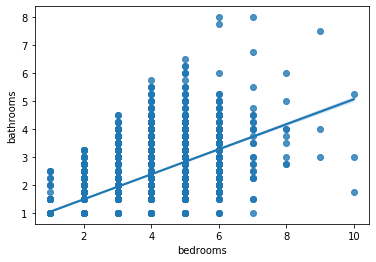

In [83]:
sns.regplot(train_set['bedrooms'], train_set['bathrooms'])

In [84]:
train_set.bedrooms.corr(train_set.bathrooms)

0.5206699207442519

In [85]:
train_set['bedbath'] = train_set['bedrooms'] + train_set['bathrooms']

In [86]:
TestVar3 = pd.concat([train_set[['sqft_living', 'bedbath', 'yr_built', 'grade', 'view']], zip_dummies], axis = 1)

lr.fit(TestVar3, y_train)

y_pred = lr.predict(TestVar3)
lr.score(TestVar3, y_train)

0.7754466777538865

In [87]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

178369.07173327138

(slightly better with both included- maybe there is a better way to combine these variables? For now returning to previous model.)

In [39]:
m = folium.Map(location = [47.5480, -121.9836])
geo = pd.read_json('neighborhoods.geojson')

NameError: name 'folium' is not defined

In [26]:
coordinates = train_set[['long', 'lat', 'zipcode']]

In [38]:
topzip1 = np.where(coordinates['zipcode'] == 98039)
topzip2 = np.where(coordinates['zipcode'] == 98004)

(array([    2,   149,   225,   297,   394,   634,   650,   669,   773,
          785,   795,   801,   934,   971,   985,  1030,  1146,  1391,
         1514,  1599,  1637,  1737,  1783,  1794,  1799,  1852,  1951,
         2027,  2132,  2257,  2360,  2363,  2604,  2619,  2651,  2666,
         2768,  3132,  3270,  3276,  3286,  3313,  3459,  3544,  3572,
         3753,  3754,  3780,  3862,  3865,  3889,  3953,  3979,  4028,
         4173,  4194,  4253,  4300,  4380,  4437,  4456,  4704,  4783,
         4820,  4854,  4947,  4958,  5021,  5103,  5137,  5141,  5169,
         5243,  5276,  5415,  5450,  5500,  5573,  5642,  5799,  6029,
         6129,  6147,  6200,  6202,  6448,  6818,  6829,  6846,  6921,
         7180,  7260,  7324,  7392,  7517,  7675,  7717,  7761,  7905,
         8107,  8111,  8123,  8134,  8178,  8181,  8206,  8225,  8231,
         8438,  8468,  8480,  8672,  8673,  8699,  8849,  8856,  8932,
         9001,  9219,  9447,  9476,  9594,  9760,  9847,  9877,  9937,
      

In [49]:
coolist = list(zip(coordinates.lat, coordinates.long))

In [46]:
from haversine import haversine

In [50]:
haversine(coolist[0], coolist[1])

38.289410671589366

In [49]:
geo['features'][2]['properties']

{'city': 'Seattle',
 'county': 'King',
 'nhood': 'Ballard',
 'nested': 'Whittier Heights',
 'area': 14195687.4922,
 'name': 'Whittier Heights'}

In [88]:
test_dummies = pd.get_dummies(test_set.zipcode, prefix = 'zip', drop_first = True)
y_train = test_set.price

X_test = pd.concat([test_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view']], test_dummies], axis = 1)

y_pred = lr.predict(X_test)
lr.score(X_test, y_train)

ValueError: shapes (4323,75) and (74,) not aligned: 75 (dim 1) != 74 (dim 0)

In [24]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

171560.33509093188

In [90]:
train_set['sqftagg'] = train_set.sqft_living + train_set.sqft_living15 
train_set.sqftagg = train_set.sqftagg/train_set.sqftagg.max()

In [91]:
y_train = train_set['price']

TestVar4 = pd.concat([train_set[['sqftagg', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view']], zip_dummies], axis = 1)

lr.fit(TestVar4, y_train)

y_pred = lr.predict(TestVar4)
lr.score(TestVar4, y_train1)

0.7636023693584106

In [92]:
lr_rsme = mean_squared_error(y_train1, y_pred)
lr_rsme**.5

183012.75951267307

In [28]:
train_set.floors.value_counts()
train_set.floors.corr(train_set.price)

0.25363771292836496

In [29]:
train_set.sqft_above.corr(train_set.price)

0.6071639001739348

In [93]:
y_train = train_set['price']

TestVar5 = pd.concat([train_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view', 'sqft_above', 'floors']], zip_dummies], axis = 1)

lr.fit(TestVar5, y_train)

y_pred = lr.predict(TestVar5)
lr.score(TestVar5, y_train)

0.7826888685838904

In [94]:
lr_rsme = mean_squared_error(y_train1, y_pred)
lr_rsme**.5

175469.15967318785

In [32]:
train_set['above_log'] = np.log(train_set.sqft_above)
train_set['living_log'] = np.log(train_set.sqft_living)

In [33]:
y_train1 = train_set['price']

X_train1 = pd.concat([train_set[['living_log', 'above_log', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view', 'floors']], zip_dummies], axis = 1)

lr.fit(X_train1, y_train1)

y_pred = lr.predict(X_train1)
lr.score(X_train1, y_train1)

0.7412463676977183

In [35]:
lr_rsme = mean_squared_error(y_train1, y_pred)
lr_rsme**.5

191471.0140112029

In [34]:
train_set['sqft_total'] = train_set.sqft_above + train_set.sqft_basement + train_set.sqft_living + train_set.sqft_lot

(array([1.2795e+04, 1.3800e+02, 1.8000e+01, 8.0000e+00, 0.0000e+00,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   2321. ,  167484.8,  332648.6,  497812.4,  662976.2,  828140. ,
         993303.8, 1158467.6, 1323631.4, 1488795.2, 1653959. ]),
 <a list of 10 Patch objects>)

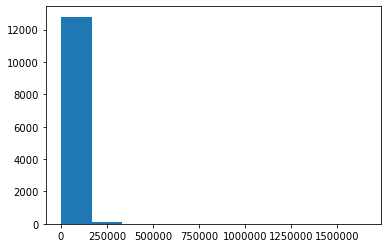

In [112]:
plt.hist(train_set.sqft_total)

In [36]:
y_train = train_set['price']

X_train = pd.concat([train_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view', 'floors', 'condition']], zip_dummies], axis = 1)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
lr.score(X_train, y_train)

0.7790944338756236

In [37]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

176914.38180226288

In [41]:
y_train = train_set['price']

X_train = pd.concat([train_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'grade', 'view', 'floors']], zip_dummies, condummies], axis = 1)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
lr.score(X_train, y_train)

0.7793992032998698

In [42]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

176792.30089476504

In [44]:
train_set.groupby(['zipcode'])['price'].mean().sort_values()

zipcode
98002    2.320431e+05
98168    2.376227e+05
98032    2.535384e+05
98001    2.787908e+05
98148    2.850328e+05
             ...     
98102    9.524970e+05
98040    1.134408e+06
98112    1.184957e+06
98004    1.420254e+06
98039    2.216827e+06
Name: price, Length: 70, dtype: float64

In [121]:
y_train = train_set['price']

X_train = pd.concat([train_set[['sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'view', 'floors']], zip_dummies, con_dummies, grade_dummies, view_dummies], axis = 1)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
lr.score(X_train, y_train)

0.812816517779559

In [122]:
lr_rsme = mean_squared_error(y_train, y_pred)
lr_rsme**.5

162852.17788387643

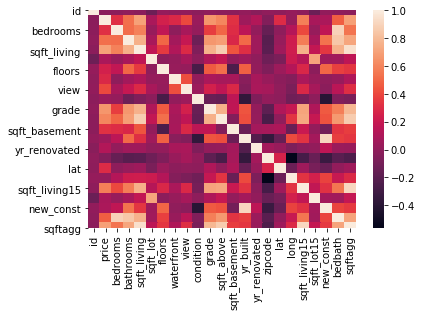

In [123]:
sns.heatmap(train_set.corr())